In [1]:
import numpy as np
import pandas as pd
import preprocess_data as prep
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from models import build_comb_lstm_att, train_model_using_cross_val, sum_regions_predictions
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [2]:
STATE = 'AM'
TEST_YEAR = 2023

In [3]:
df = prep.load_cases_data()
df = df.loc[df.uf == STATE]
enso = prep.load_enso_data()

# generate the samples to train and test based on the regional data 
X_train, y_train = prep.generate_regional_train_samples(df, enso, TEST_YEAR, columns_to_normalize=['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], episcanner = True)

In [4]:
LOSS = 'mse'

In [5]:
batch_size = 4
model = build_comb_lstm_att( hidden=64, features=8, predict_n=52, look_back=89, loss=LOSS, 
                  stateful = False, batch_size = batch_size,  optimizer = Adam(learning_rate=0.001), activation = 'relu')

model 

/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (4, 89, 8)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention           │ (4, 89, 8)        │         65 │ input_layer[0][0] │
│ (SeqSelfAttention)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (4, 89, 8)        │          0 │ Attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (4, 89, 64)       │     18,688 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (4, 89, 16)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (4, 89, 64)       │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (4, 64)           │     20,736 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (4, 64)           │     33,024 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (4, 64)           │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (4, 64)           │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (4, 52)           │      3,380 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (4, 52)           │      3,380 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (4, 52)           │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (4, 52)           │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (4, 104)          │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (4, 52)           │      5,460 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,733 (330.99 KB)

 Trainable params: 84,733 (330.99 KB)

 Non-trainable params: 0 (0.00 B)

None


<Functional name=functional, built=True>

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [7]:
epochs = 1000

In [8]:
TB_callback = TensorBoard(
            log_dir="./tensorboard",
            histogram_freq=0,
            write_graph=True,
            write_images=True,
            update_freq='epoch',
            # embeddings_freq=10
        )

hist = model.fit(
                X_train,
                y_train,
                batch_size=4,
                epochs=epochs,
                verbose=1,
                validation_data=(X_val, y_val),
                callbacks=[TB_callback]
                )


Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.0105 - loss: 0.0234 - mape: 6190537.5000 - mse: 0.0138 - val_accuracy: 0.0000e+00 - val_loss: 0.0170 - val_mape: 1912313.8750 - val_mse: 0.0075
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0044 - loss: 0.0241 - mape: 3060974.7500 - mse: 0.0146 - val_accuracy: 0.0000e+00 - val_loss: 0.0168 - val_mape: 3020829.2500 - val_mse: 0.0074
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0747 - loss: 0.0270 - mape: 2883117.5000 - mse: 0.0176 - val_accuracy: 0.0000e+00 - val_loss: 0.0164 - val_mape: 3360849.5000 - val_mse: 0.0070
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0347 - loss: 0.0203 - mape: 2936702.0000 - mse: 0.0109 - val_accuracy: 0.0000e+00 - val_loss: 0.0163 - val_mape: 5584821.5000 - val_mse: 0.0069
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1079 - loss: 0.0196 - mape: 4156700.0000 - mse: 0.0103 - val_accuracy: 0.0000e+00 - val_l

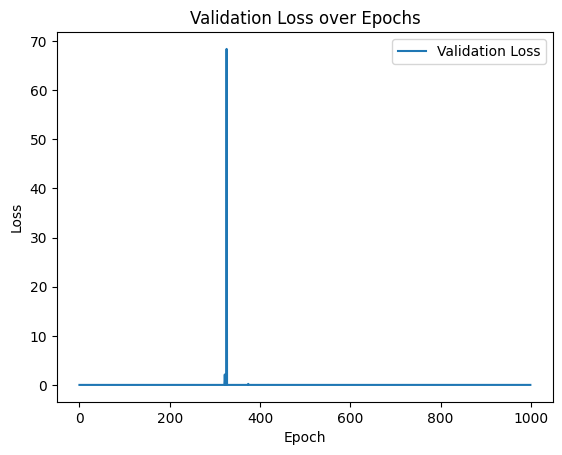

In [9]:
plt.figure()
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

In [10]:
model_name = 'comb_att'
columns_to_normalize=['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                           'peak_week', 'perc_geocode']

In [11]:
%%time
model.save(f'./saved_models/model_groc_{STATE}_{TEST_YEAR-1}_{model_name}.keras')

df_preds_23 = sum_regions_predictions(model, df, enso, TEST_YEAR, columns_to_normalize, True, False)

df_preds_23['adm_1'] = STATE
df_preds_23['adm_0'] = 'BR'
df_preds_23['adm_2'] = pd.NA

df_preds_23.to_csv(f'./predictions/preds_groc_{STATE}_{TEST_YEAR}_{model_name}.csv', index = False)


CPU times: user 3min 10s, sys: 406 ms, total: 3min 10s
Wall time: 3min 11s


In [12]:
df_23_base = pd.read_csv(f'./predictions/preds_{STATE}_{TEST_YEAR}_{model_name}.csv')
df_23_base.dates = pd.to_datetime(df_23_base.dates)
df_23_base.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2022-10-09,44.329873,64.315007,87.455904,AM,BR,NaN
1,2022-10-16,61.940275,91.790425,119.712031,AM,BR,NaN
2,2022-10-23,52.705472,79.575908,102.222861,AM,BR,NaN
3,2022-10-30,65.619996,89.718716,115.818418,AM,BR,NaN
4,2022-11-06,89.985849,129.303003,165.489727,AM,BR,NaN


In [13]:
df_preds_23.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2022-10-09,1.062677,18.873428,41.716454,AM,BR,<NA>
1,2022-10-16,0.000000,25.077971,53.041004,AM,BR,<NA>
2,2022-10-23,4.708165,36.962774,60.252324,AM,BR,<NA>
3,2022-10-30,0.819016,38.962451,69.337081,AM,BR,<NA>
4,2022-11-06,0.000000,20.541958,49.864915,AM,BR,<NA>


In [14]:
data_w = df[['casos']].resample('W-SUN').sum()

data_w.head()

,casos
date,
2010-01-03,191
2010-01-10,183
2010-01-17,73
2010-01-24,100
2010-01-31,113


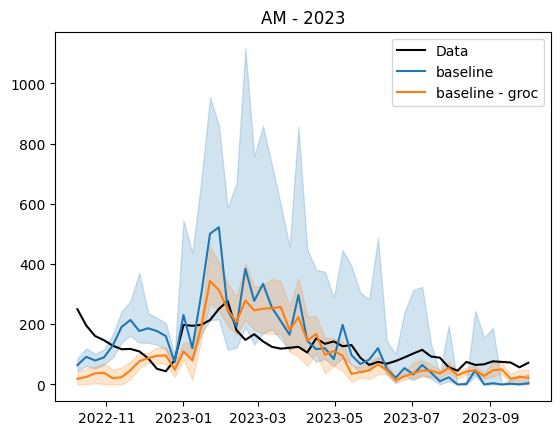

In [15]:
fig,ax = plt.subplots()

ax.plot(data_w.loc[data_w.index.isin(df_23_base.dates)].casos, label = 'Data', color = 'black')
ax.plot(df_23_base.dates, df_23_base.preds, label ='baseline')
ax.fill_between(df_23_base.dates, df_23_base.lower, df_23_base.upper,  color = 'tab:blue', alpha = 0.2)


ax.plot(df_preds_23.dates, df_preds_23.preds, label ='baseline - groc')

ax.fill_between(df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax.legend()

ax.set_title(f'{STATE} - {TEST_YEAR}')

plt.show()

### Training the model for 2024:

In [16]:
from keras.models import load_model

model = load_model(f'./saved_models/model_groc_{STATE}_2022_{model_name}.keras')

In [17]:
TEST_YEAR = 2024

In [18]:
X_train, y_train = prep.generate_regional_train_samples(df, enso, TEST_YEAR, columns_to_normalize=['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], episcanner = True)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [19]:
hist = model.fit(
                X_train,
                y_train,
                batch_size=4,
                epochs=1000,
                verbose=1,
                validation_data=(X_val, y_val),
                callbacks=[TB_callback]
                )

Epoch 1/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.2461 - loss: 0.0137 - mape: 3241709.7500 - mse: 0.0049 - val_accuracy: 0.2400 - val_loss: 0.0168 - val_mape: 1888501.2500 - val_mse: 0.0080
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1949 - loss: 0.0127 - mape: 3218938.2500 - mse: 0.0039 - val_accuracy: 0.1600 - val_loss: 0.0169 - val_mape: 3460784.0000 - val_mse: 0.0081
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1921 - loss: 0.0124 - mape: 3122810.2500 - mse: 0.0036 - val_accuracy: 0.1600 - val_loss: 0.0188 - val_mape: 5751442.0000 - val_mse: 0.0100
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1159 - loss: 0.0140 - mape: 4509397.0000 - mse: 0.0052 - val_accuracy: 0.2000 - val_loss: 0.0169 - val_mape: 2935874.2500 - val_mse: 0.0081
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.1746 - loss: 0.0118 - mape: 3375021.2500 - mse: 0.0030 - val_accuracy: 0.0800 - val_loss: 0.0205 - val_ma

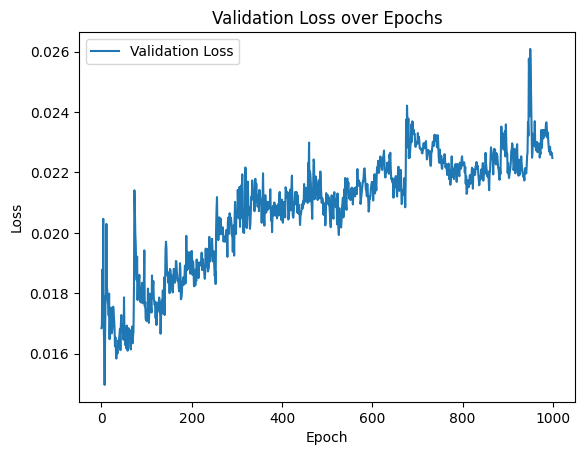

In [20]:
plt.figure()
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

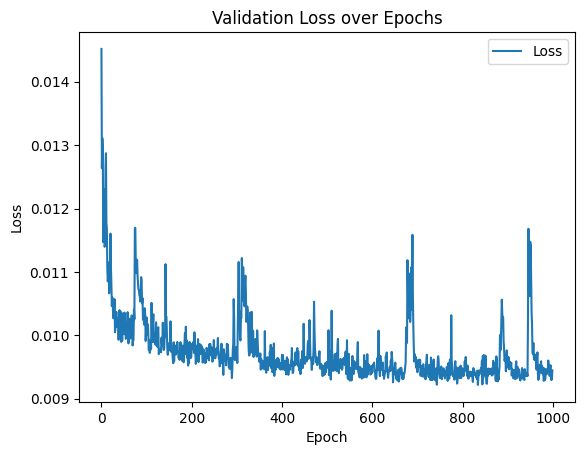

In [21]:
plt.figure()
plt.plot(hist.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

In [22]:
%%time
model.save(f'./saved_models/model_groc_{STATE}_{TEST_YEAR-1}_{model_name}.keras')

df_preds_24 = sum_regions_predictions(model, df, enso, TEST_YEAR, columns_to_normalize, True, False)

df_preds_24['adm_1'] = STATE
df_preds_24['adm_0'] = 'BR'
df_preds_24['adm_2'] = pd.NA

df_preds_24.to_csv(f'./predictions/preds_groc_{STATE}_{TEST_YEAR}_{model_name}.csv', index = False)


CPU times: user 3min 7s, sys: 390 ms, total: 3min 8s
Wall time: 3min 8s


In [23]:
df_24_base = pd.read_csv(f'./predictions/preds_{STATE}_{TEST_YEAR}_{model_name}.csv')
df_24_base.dates = pd.to_datetime(df_24_base.dates)
df_24_base.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2023-10-08,358.364047,459.236369,559.087565,AM,BR,NaN
1,2023-10-15,321.519089,394.166831,464.353249,AM,BR,NaN
2,2023-10-22,212.979000,269.589592,328.545220,AM,BR,NaN
3,2023-10-29,123.689112,179.334129,242.622315,AM,BR,NaN
4,2023-11-05,48.435063,105.030273,162.898274,AM,BR,NaN


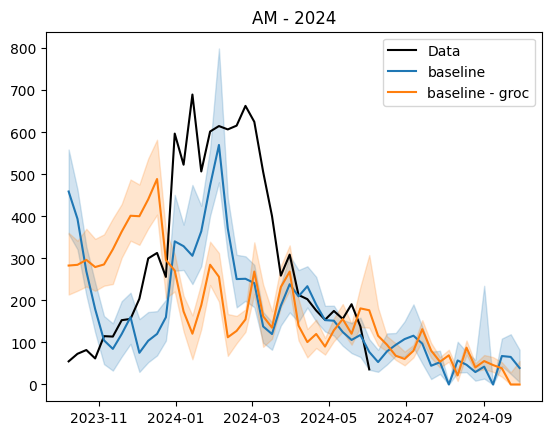

In [24]:
fig,ax = plt.subplots()

ax.plot(data_w.loc[data_w.index.isin(df_24_base.dates)].casos, label = 'Data', color = 'black')
ax.plot(df_24_base.dates, df_24_base.preds, label ='baseline')
ax.fill_between(df_24_base.dates, df_24_base.lower, df_24_base.upper,  color = 'tab:blue', alpha = 0.2)


ax.plot(df_preds_24.dates, df_preds_24.preds, label ='baseline - groc')

ax.fill_between(df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax.legend()

ax.set_title(f'{STATE} - {TEST_YEAR}')

plt.show()